In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


In [5]:
path = 'data/features_3_sec.csv'
data = pd.read_csv(path)
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [6]:
data = data.sample(frac=1, random_state=1240).reset_index(drop=True)
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,metal.00097.0.wav,66149,0.446523,0.077343,0.125813,0.000230,1084.475564,56765.853273,1885.164402,46173.544686,...,16.758436,-5.082604,17.809443,0.733861,25.706236,-0.285895,21.780428,0.655277,16.065197,metal
1,hiphop.00095.8.wav,66149,0.587401,0.055307,0.083302,0.001139,2617.381435,298870.238834,2240.388564,50496.395875,...,20.769207,-3.020652,31.826502,2.775115,24.167973,-6.293679,28.987467,-5.233632,27.237871,hiphop
2,metal.00018.2.wav,66149,0.600416,0.051254,0.114570,0.000087,2386.507519,19030.875872,1654.035708,8389.897095,...,23.200424,-5.212678,18.016176,0.918574,23.405022,0.641828,16.893543,1.671759,15.851320,metal
3,reggae.00031.6.wav,66149,0.515384,0.078020,0.092585,0.001890,1637.524012,390436.598740,2030.631214,180050.065902,...,70.975830,-4.660653,47.511082,2.496887,42.138851,-1.823643,43.491833,1.523607,44.292225,reggae
4,reggae.00011.8.wav,66149,0.487252,0.082184,0.074159,0.001439,2355.437046,424809.067618,2465.181647,145506.996952,...,48.184502,-4.413498,52.270344,4.086631,69.044098,-1.092492,39.011402,5.441519,55.162216,reggae


In [7]:
data.shape

(9990, 60)

In [8]:
#procesamos los datos
X = data.drop(['filename', 'label'], axis=1).values
y = data['label']

#convertimos los generos a numeros
le = LabelEncoder()
y = le.fit_transform(y)

#normalizamos los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

#separamos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1240)

#convertimos los datos a tensores
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)

In [9]:
#creamos la red neuronal

class Classifier(nn.Module):
    def __init__(self,input_size,hidden1, hidden2, hidden3, hidden4,
                hidden5, hidden6, output_size):
        '''
        Define las caracteristicas de una red completamente conectada 
        de tres capas, recibe la cantidad de elementos de entrada, el 
        número de capas ocultas y el número de elementos de salida. 
        Entre cada capa agrega una función de activación logistica.
        '''
        super(Classifier,self).__init__()
        
        #Creamos las capas y le agregamos dropout
        self.c1 = nn.Linear(in_features = input_size, out_features = hidden1)
        self.dropout1 = nn.Dropout(0.25)
        self.c2 = nn.Linear(in_features = hidden1, out_features = hidden2)
        self.dropout2 = nn.Dropout(0.2)
        self.c3 = nn.Linear(in_features = hidden2, out_features = hidden3)
        self.dropout3 = nn.Dropout(0.2)
        self.c4 = nn.Linear(in_features = hidden3, out_features = hidden4)
        self.dropout4 = nn.Dropout(0.1)
        self.c5 = nn.Linear(in_features = hidden4, out_features = hidden5)
        self.dropout5 = nn.Dropout(0.1)
        self.c6 = nn.Linear(in_features = hidden5, out_features = hidden6)
        self.dropout6 = nn.Dropout(0.1)
        self.c7 = nn.Linear(in_features = hidden6, out_features = output_size)

        #agregamos softmax
        self.softmax = nn.Softmax(dim=1)

        #definimos la función de error
        self.funcion_error = nn.CrossEntropyLoss()
        self.error = 0

    def forward(self, X):
        '''Función de propagación hacia delante '''

        output = F.sigmoid(self.c1(X))
        output = self.dropout1(output)
        output = F.sigmoid(self.c2(output))
        output = self.dropout2(output)
        output = F.sigmoid(self.c3(output))
        output = self.dropout3(output)
        output = F.sigmoid(self.c4(output))
        output = self.dropout4(output)
        output = F.sigmoid(self.c5(output))
        output = self.dropout5(output)
        output = F.sigmoid(self.c6(output))
        output = self.dropout6(output)
        output = self.c7(output)
        output = self.softmax(output)

        return output
    
    def train(self, train_X, train_Y, optimizer, ciclos):
        '''Función que entrena a la red neuronal.
        Al final del entrenamiento muestra una gráfica del error'''

        #lista para guardar el error
        error_lista = []
        epocas = [i for i in range(ciclos)]

        #entranamos a la red
        for ciclo in range(ciclos):
            #hacemos la feedforward
            output = self.forward(train_X)
            #calculamos el error y lo guardamos

            # print(f'output: {output.shape}')
            # print(f'train_Y: {train_Y.shape}')

            error = self.funcion_error(output, train_Y)
            error_lista.append(error.item())
            
            #limpiamos el gradiente
            optimizer.zero_grad()
            #hacemos backpropagation y actualizamos los pesos
            error.backward()
            optimizer.step()

            #guardamos el error
            self.error = error.item()

            #imprimimos el error cada 100 ciclos
            if ciclo % 50 == 0:
                print(f'ciclo: {ciclo:3}  error: {self.error:.5f}')

        #graficamos el error
        plt.plot(epocas, error_lista, color = '#8315C2')
        plt.ylabel('Error')
        plt.xlabel('Epocas')
        plt.grid()
        plt.show()

    def predict(self, test_X):
        '''Función que predice los valores de prueba'''
        with torch.no_grad():
            output = self.forward(test_X)
        
        return output
    
    def confusion_matrix(self, test_X, test_Y):
        '''Función que muestra la matriz de confusión'''
        with torch.no_grad():
            output = self.forward(test_X)
        
        #obtenemos el genero con mayor probabilidad
        y_pred = np.argmax(output, axis=1)
        y_test = test_Y

        #calculamos la matriz de confusión
        cm = confusion_matrix(y_test, y_pred)

        #mostramos la matriz de confusión
        cmd = ConfusionMatrixDisplay(cm)
        cmd.plot()
        plt.show()

        #mostramos el reporte de clasificación
        print(classification_report(y_test, y_pred))
        

In [10]:
#inicializamos la red 
red_clas = Classifier(58, 1024, 512, 512, 256, 128, 64, 10)
red_clas.load_state_dict(torch.load('red_clas.pth'))

# optimizer = torch.optim.Adam(red_clas.parameters(), lr = 0.00001)

<All keys matched successfully>

In [11]:
@interact_manual()
def entrenaRedC():
        red_clas.train(X_train, y_train, optimizer,  3000)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

C:\Users\PC\AppData\Roaming\Python\Python310\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


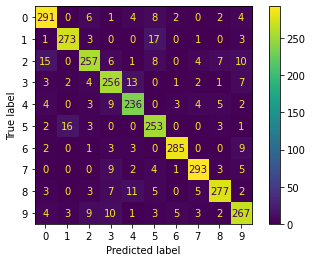

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       318
           1       0.93      0.92      0.92       298
           2       0.89      0.83      0.86       308
           3       0.85      0.89      0.87       289
           4       0.87      0.89      0.88       266
           5       0.85      0.91      0.88       278
           6       0.96      0.94      0.95       303
           7       0.94      0.92      0.93       317
           8       0.92      0.88      0.90       313
           9       0.86      0.87      0.87       307

    accuracy                           0.90      2997
   macro avg       0.90      0.90      0.90      2997
weighted avg       0.90      0.90      0.90      2997



In [12]:
red_clas.confusion_matrix(X_test, y_test)

In [13]:
#guardamos la red entrenada
# torch.save(red_clas.state_dict(), 'red_clas.pth')
